In [285]:
print('Notes of lecture 3\nBuilding makemore Part 3: Activations & Gradients, BatchNorm')

Notes of lecture 3
Building makemore Part 3: Activations & Gradients, BatchNorm


In [286]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline


In [287]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [288]:
len(words)

32033

In [289]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))

stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}

vocab_size = len(itos)

print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [290]:
# build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [291]:
# MLP revisited

n_embd = 10      # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**2) #0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

12297


In [292]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]                           # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1            # hidden layer pre-activation
    bnmeani = hpreact.mean(axis = 0, keepdim = True)
    bnstdi = hpreact.std(axis = 0, keepdim = True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias #batch norm layer
    with torch.no_grad(): #updating mean and standerd deviation without gradient descent 
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)               # hidden layer
    logits = h @ W2 + b2                  # output layer
    loss = F.cross_entropy(logits, Yb)    # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1877
  20000/ 200000: 2.3251
  30000/ 200000: 2.4606
  40000/ 200000: 1.9243
  50000/ 200000: 2.4115
  60000/ 200000: 2.3451
  70000/ 200000: 2.0881
  80000/ 200000: 2.3196
  90000/ 200000: 2.1825
 100000/ 200000: 1.9393
 110000/ 200000: 2.2953
 120000/ 200000: 1.9052
 130000/ 200000: 2.3272
 140000/ 200000: 2.3035
 150000/ 200000: 2.2185
 160000/ 200000: 1.9161
 170000/ 200000: 1.7907
 180000/ 200000: 2.1811
 190000/ 200000: 1.8123


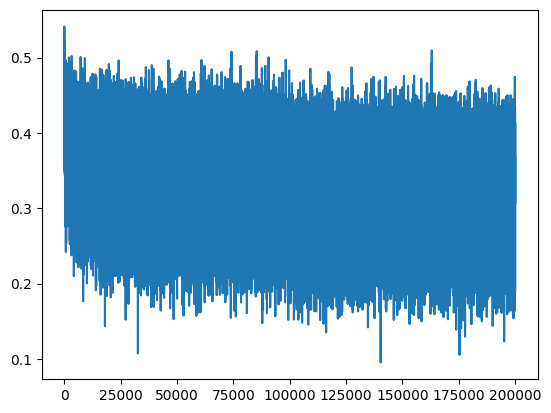

In [293]:
plt.plot(lossi)
#You can see that the plot of the loss dosent have a hockey shape appearance because the loss started small

In [295]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    X, y = {
        'train': (Xtr, Ytr),
        'val':   (Xdev, Ydev),
        'test':  (Xte, Yte),
    }[split]

    emb = C[X]                                   # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) 
    hpreact =  embcat @ W1 + b1       # concat into (N, block_size * n_embd)
    hpreact = bngain * (hpreact - hpreact.mean(axis = 0, keepdim = True)) / hpreact.std(axis = 0, keepdim = True) + bnbias 
    h = torch.tanh(hpreact)              # (N, n_hidden)
    logits = h @ W2 + b2                          # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.059954881668091
val 2.1038501262664795


In [298]:
import time
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]        # (1, block_size, n_embd)
        hpreact = emb.view(1, -1) @ W1 + b1
        hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias 
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))  # decode and print the generated word

carmahzaan.
harli.
jari.
reety.
salaysie.
mahnee.
delynn.
jareei.
nellara.
chaiiv.
kaleigh.
ham.
joce.
quinthorlen.
alvin.
quinterri.
jaryxia.
kael.
drudi.
edde.


In [ ]:
#batch normalization
#so we want the pre activation to be gaussian (zero mean and approx 1 standerd deviation) we dont want the pre activations to be way to large or small
# we want the h preactivation to be gaussian so why not make it gaussian
#what we want to do is perform these operations on the h preactivation subtract the mean and divide by the the standerd deviation 
#the problem with this is that you will not achieve good result with this, because we want these to be roughly gaussian but only at intialization we dont want these o be forced to be gaussian
#we would like to allow the neural net to move it around potentially make it more defuse/sharp and we would like baCK PROPOGATION to tell us how this distribution moves around
#so to implent this we would be introducing an additional component scale and shift (given in the batch normalization paper) 
#the additional gain will be termed as batch normalization gain (bngain) and we will also have batch normaliztion bias (bnbias)
# here batch normalization might not do much but as you increase the number of hidden layers it effets how fast the network converges greatly and decreases the loss
#you would have to add batch normalization layers in your neural network
#batch normalization comes at a cost, now the hpreact and logits for any one input example are not just a function of that example and its input but they are also the function of all the other examples that happened to come for a ride in that batch
#so once we have trained the neural net and feeding it a single example and get a prediction out, since we have introduced batch normalization the neural net expects a batch as an input
#Thats the problem how do we get a single output from the neural net
#so what we will do is calculate and set the batch norm mean and standerd deviation while training the neural net.
#Also when we train the neural net with batch normalization layer we dont need bias for the batch normalization layers because it simply gets subtracted while doing batch normalization ,insted we have batch normalization bias
print(hpreact.shape)
hpreact.mean(axis = 0, keepdim = True).shape

torch.Size([1, 200])


torch.Size([1, 200])